In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import binom

In [2]:
random.seed(42)
P = 0.5

We are going to do an analysis that highlights the multiple testing problem. The main idea is that if we are running several independent statistical tests at the $\alpha = 0.05$ level, we actually need to correct our confidence level to be more stringent to account for the inflating Type I error. Simply stated, the more tests, the better chance of a false positive.

For this example we will begin with the Null Hypothesis that a randomly generated integer from 0 to 1 has an equal chance of coming up even or odd. Our p-values will come from the two-tailed binomial test. Let's define some parameters: $M$ is the number of random integers chosen, $P$ is the equal probablity null hypothesis of even or odd, and $N$ is the number of independent tests being run simultaneously. We have an upper bound for the Family-Wise Error Rate (FWER), which is the inflating <i>group</i> $\alpha$ level, given by $1 - (1 - \alpha)^N$.

In [3]:
"""def pval_two_tail(M_,k):
    temp_binomial = binom(M_,P) 
    if not isinstance(k, list):
        return 2.*temp_binomial.cdf(min(M_-k,k))
    return [2.*temp_binomial.cdf(min(M_-i,i)) for i in k]
"""

'def pval_two_tail(M_,k):\n    temp_binomial = binom(M_,P) \n    if not isinstance(k, list):\n        return 2.*temp_binomial.cdf(min(M_-k,k))\n    return [2.*temp_binomial.cdf(min(M_-i,i)) for i in k]\n'

We are going to be testing the null hypothesis of equal evens and odds at $\alpha = 0.05$ and we can do this by checking to see if we have $n_{\text{evens}} \leq \text{crit}$ or $n_{\text{evens}} \geq M - \text{crit}$. Where the critical value ($\text{crit}$) is defined by a p-value less than $\alpha$. Given a critical number of evens we would reject the null hypothesis at the $0.05$ level.

We will run this analysis $10000$ times to get an asymptotic value for the FWER. That is, how many times do we reject the null hypothesis incorrectly (Type I Error) at least once in $N$ independent tests. This value should be upper bounded by $1 - (1-\alpha)^N$.

In [4]:
def fwer_upper_bound(alpha_, N_):
    return 1 - (1 - alpha_)**N_

We use the function <i>asymp</i> to count the number of false positive analyses in $NN = 10000$ runs.

In [5]:
def asymp(N_, NN_, M_, alpha_):
    results = np.random.randint(0, 2, size=(NN_, N_, M_))
    evens = np.sum(results % 2 == 0, axis=2)
    temp_binomial = binom(M_,P)
    temp_crit = int(temp_binomial.ppf(alpha_ / 2)-1.)
    false_positives = np.sum((evens <= temp_crit) | (evens >= M_ - temp_crit), axis=1) > 0
    return np.mean(false_positives)

We will run $N$ from $1$ to $1000$ statistical tests, and also $M$ in $[6, 25, 200]$ random coins flipped.

In [13]:
numer_tests = np.logspace(0,3,15)
low_M = 6
numer_fwer_low = [asymp(int(i), 10000, low_M, 0.05) for i in numer_tests]

In [14]:
med_M = 25
numer_fwer_med = [asymp(int(i), 10000, med_M, 0.05) for i in numer_tests]

In [15]:
high_M = 200
numer_fwer_high = [asymp(int(i), 10000, high_M, 0.05) for i in numer_tests]

Let's correct for the rising $\alpha$ with the Bonferroni correction where our new $\alpha = \alpha/N$.

In [16]:
numer_fwer_bonferroni = [asymp(int(i), 10000, med_M, 0.05/i) for i in numer_tests]

We compare the upper bound to the numerical false positive rate for our choice of $N$ and $M$.

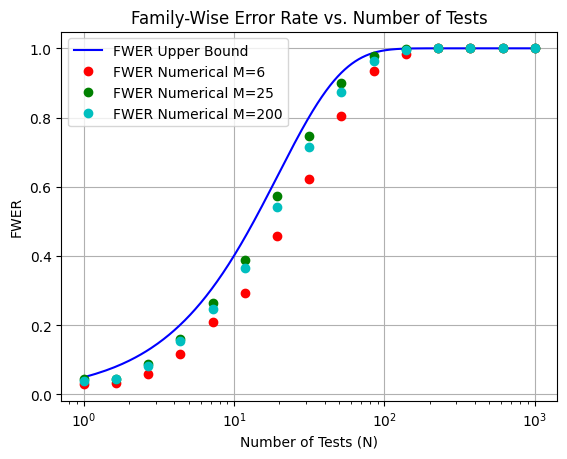

In [17]:
ubound_tests = np.arange(1, 1000, 0.1)
ubound_fwer = 1 - (1 - 0.05)**ubound_tests

plt.plot(ubound_tests, ubound_fwer, label='FWER Upper Bound', color='blue')
plt.plot(numer_tests, numer_fwer_low, 'ro',label=f'FWER Numerical M={low_M}')
plt.plot(numer_tests, numer_fwer_med, 'go',label=f'FWER Numerical M={med_M}')
plt.plot(numer_tests, numer_fwer_high, 'co',label=f'FWER Numerical M={high_M}')
plt.xlabel('Number of Tests (N)')
plt.ylabel('FWER')
plt.xscale('log')
plt.title('Family-Wise Error Rate vs. Number of Tests')
plt.legend()
plt.grid()
plt.show()

Applying the Bonferroni Correction eliminates the dependence on the number of tests but because it is the most simple correction it is also the most conservative.

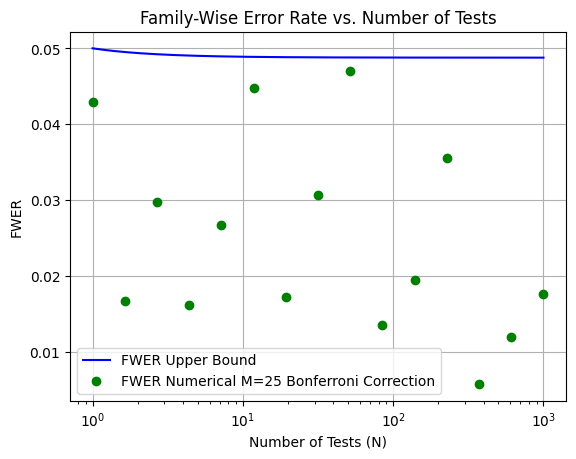

In [19]:
ubound_fwer_bonferroni = 1 - (1 - 0.05/ubound_tests)**ubound_tests

plt.plot(ubound_tests, ubound_fwer_bonferroni, label='FWER Upper Bound', color='blue')
plt.plot(numer_tests, numer_fwer_bonferroni, 'go',label=f'FWER Numerical M={med_M} Bonferroni Correction')
plt.xlabel('Number of Tests (N)')
plt.ylabel('FWER')
plt.xscale('log')
plt.title('Family-Wise Error Rate vs. Number of Tests')
plt.legend()
plt.grid()
plt.show()

Note how $M = 25$ has a larger false positive rate than $M = 200$. This is counter-intuitive but can be explained by calculating the p-value of the critical number of coin flips. Although the trend of critical p-values tends to $\alpha$, it oscillates wildly. For our choice of $M$ we got closer to $\alpha = 0.05$ with a lower $M = 25$.

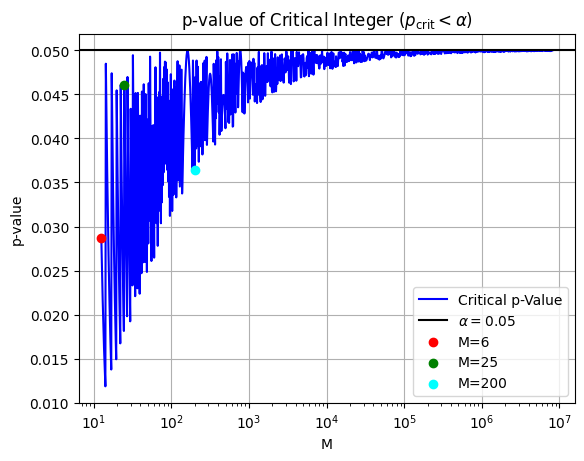

In [11]:
Ms = np.logspace(np.log(3),np.log(1000),1000)
bins = [binom(i,P) for i in Ms]
crits = [int(i.ppf(0.05 / 2)-1.) for i in bins]
pvs = [2.*bins[i].cdf(min(Ms[i]-crits[i],crits[i])) for i in range(len(Ms))]
index = [min(range(len(Ms)), key=lambda i: abs(Ms[i]-low_M)), 
             min(range(len(Ms)), key=lambda i: abs(Ms[i]-med_M)), 
             min(range(len(Ms)), key=lambda i: abs(Ms[i]-high_M))
             ]
colors = ['red', 'green', 'cyan']
labels = [f'M={low_M}', f'M={med_M}', f'M={high_M}']
plt.figure()
plt.plot(Ms, pvs, color='blue', label='Critical p-Value')
plt.axhline(0.05, color='black', label=f'$\\alpha = 0.05$')
for i in range(len(index)):
    plt.scatter(Ms[index[i]], pvs[index[i]], color=colors[i], label=labels[i], zorder=2)
plt.xscale('log')
plt.xlabel('M')
plt.ylabel('p-value')
plt.title('p-value of Critical Integer $(p_{\\text{crit}}< \\alpha)$')
plt.legend()
plt.grid()
plt.show()